# Initial Setup

In [1]:
import sys
import os
!git clone https://github.com/a3i-2022-2023/04-rul
sys.path.append(os.getcwd() + "/04-rul")

fatal: destination path '04-rul' already exists and is not an empty directory.


In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
import re
import matplotlib.pyplot as plt
import numpy as np
import notebooks.util.util as util

from sklearn.metrics import mean_squared_error

from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

# Objectives

Given the top x games and their trand, we aim at:

- Predicting their trend in the near future in order to evaluate their "remaining useful life", predicting when interest may begin to fade, in order to forecast when to release update
- Fill missing values in order to complete a trend

# Dataset Analysis

In [3]:
# Get the dataset
df = pd.read_csv(os.getcwd() + "/game-data/Twitch_game_data.csv", encoding='cp1252')

The Dataset has:

- **Rank**

    For each month the ranking of the top 200 games
   
- **Game**

    The name of the videogame
    
- **Month**

    Int representing the month
   
- **Year**

     Int representing the year
     
- **Hours_watched**

    ??
   
- **Hours_Streamed**

    Total number of hours collectively streamed by all the channels that streamed that game 
    
- **Peak_viewers**

    Maximum number of viewers at one time that watched that game
   
- **Peak_channels**

     Maximum number of channels at one time that streamed that game
     
- **Streamers**

    Number of total streamers that streamed that game
   
- **Avg_viewers**

    ??
    
- **Avg_channels**

    ??
   
- **Avg_viewer_ratio**

    ??
    
     

In [4]:
# Quick glance at its structure
df

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,League of Legends,1,2016,94377226,1362044 hours,530270,2903,129172,127021,1833,69.29
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105 hours,372654,2197,120849,64378,1117,57.62
2,3,Dota 2,1,2016,45185893,433397 hours,315083,1100,44074,60815,583,104.26
3,4,Hearthstone,1,2016,39936159,235903 hours,131357,517,36170,53749,317,169.29
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578 hours,71639,3620,214054,21740,1549,14.03
...,...,...,...,...,...,...,...,...,...,...,...,...
16995,196,Tom Clancy's The Division 2,1,2023,666943(118.3%),97138(59.5%),2759(49.9%),249(48.2%),12805(68.1%),897(118.2%),130(60.5%),6.87(36.9%)
16996,197,Persona 5 Royal,1,2023,664503(-2.9%),68310(2.7%),10494(19.6%),198(4.8%),7475(4.8%),894(-2.9%),91(2.2%),9.73(-5.4%)
16997,198,Bloodborne,1,2023,663078(59.1%),45522(31.8%),9455(30.4%),117(8.3%),8355(27.5%),892(59.3%),61(32.6%),14.57(20.7%)
16998,199,PowerWash Simulator,1,2023,657644(356.0%),18494(53.7%),63757(473.9%),192(346.5%),6589(42.3%),885(356.2%),24(50%),35.56(196.6%)


In [5]:
print("The dataset has", df.shape[0], "rows")

The dataset has 17000 rows


Immediately it's noticeable that:

- Month and Year can be merged in one single value Date which encapsulate the same concepte 
- Hours_Streamed is a string since it has the adjective hourse in its values, we have to clean this column and convert it to Int values to use it correctly
- Hours_watched, Hours_Streamed, Peak_viewers, Peak_channels, Streamers, Avg_viewers, Avg_channels and Avg_viewer_ratio all change format at one point in time, including also a percentage (which represent????). We have to format each of these column to their single Int value to use them correctly

But let's analyze a bit more our data

In [6]:
df.describe()

,Rank,Month,Year
count,17000.000000,17000.000000,17000.000000
mean,100.500000,6.435294,2019.047059
std,57.736003,3.482654,2.034504
min,1.000000,1.000000,2016.000000
25%,50.750000,3.000000,2017.000000
50%,100.500000,6.000000,2019.000000
75%,150.250000,9.000000,2021.000000
max,200.000000,12.000000,2023.000000


In [7]:
df.dtypes

Rank                 int64
Game                object
Month                int64
Year                 int64
Hours_watched       object
Hours_Streamed      object
Peak_viewers        object
Peak_channels       object
Streamers           object
Avg_viewers         object
Avg_channels        object
Avg_viewer_ratio    object
dtype: object

In [8]:
print("Number of unique games in the dataset:",len(list(df["Game"].unique())))

Number of unique games in the dataset: 2003


# Dataset cleaning

## Clean and change format of each object column with values

In [9]:
# Get the number in the string
def getNumber(x):
    return int(re.match("\d+", x).group())

In [10]:
df.rename(columns={"Hours_Streamed": "Hours_streamed"}, inplace=True)

In [11]:
columns_to_convert = ['Hours_watched', 'Hours_streamed', 'Peak_viewers', 'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels', 'Avg_viewer_ratio']

In [12]:
for column_name in columns_to_convert:
    df[column_name] = df[column_name].map(lambda x: getNumber(x))

In [13]:
df

,Rank,Game,Month,Year,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57
2,3,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104
3,4,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14
...,...,...,...,...,...,...,...,...,...,...,...,...
16995,196,Tom Clancy's The Division 2,1,2023,666943,97138,2759,249,12805,897,130,6
16996,197,Persona 5 Royal,1,2023,664503,68310,10494,198,7475,894,91,9
16997,198,Bloodborne,1,2023,663078,45522,9455,117,8355,892,61,14
16998,199,PowerWash Simulator,1,2023,657644,18494,63757,192,6589,885,24,35


In [14]:
df.dtypes

Rank                 int64
Game                object
Month                int64
Year                 int64
Hours_watched        int64
Hours_streamed       int64
Peak_viewers         int64
Peak_channels        int64
Streamers            int64
Avg_viewers          int64
Avg_channels         int64
Avg_viewer_ratio     int64
dtype: object

## Check for NaN values in the dataset

In [15]:
df.isnull().sum()

Rank                0
Game                1
Month               0
Year                0
Hours_watched       0
Hours_streamed      0
Peak_viewers        0
Peak_channels       0
Streamers           0
Avg_viewers         0
Avg_channels        0
Avg_viewer_ratio    0
dtype: int64

In [16]:
df[df['Game'].isna()]

,Rank,Game,Month,Year,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
7561,162,NaN,2,2019,317951,77004,30919,5804,21758,473,114,4


Since there is only one game name with it's name missing, we can't draw any conclusion on what game it might be, so we decided to drop it.

(can we do something with it?)

In [17]:
df = df.dropna()

In [18]:
df[df['Game'].isna()]

,Rank,Game,Month,Year,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio


## Merge Month and Year in Date

In [19]:
# Create merged unique date representation
df['Date'] = df.apply(lambda row: pd.to_datetime(str(row['Month']) + str(row['Year']),format='%m%Y'), axis=1)
del df['Month']
del df['Year']

C:\Users\Enri\AppData\Local\Temp/ipykernel_9036/2908505859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df.apply(lambda row: pd.to_datetime(str(row['Month']) + str(row['Year']),format='%m%Y'), axis=1)


In [20]:
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                      ):
#     print(len(tmp))
# 
#lol, Counter-Strike: Global Offensive, Hearthstone, 

## Check for duplicates

In [21]:
duplicates = df[df.duplicated()]
duplicates 

,Rank,Game,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Date


We do not have any duplicates, but this information alone is not very useful.

Since we have a lot of different values, an exact copy of a row was very unlikely, and fortunately we did not have any row duplicates.

But we still could have duplicates of the same game in the same date but with differen measurements, due to some mistake in the data gathering process.

In [22]:
duplicates = df[df[['Game','Date']].duplicated(keep=False)]
duplicates 

,Rank,Game,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Date
1915,116,Resident Evil,251183,3976,9871,21,7420,338,5,63,2016-10-01
1979,180,Resident Evil,143542,4113,9577,31,1047,193,5,34,2016-10-01
6474,75,Dungeons & Dragons,790966,21961,38597,181,2876,1100,30,36,2018-09-01
6502,103,Dungeons & Dragons,550645,10198,40261,127,2091,765,14,54,2018-09-01
7212,13,Resident Evil 2,16394917,449333,314244,6488,70644,22065,604,36,2019-01-01
7214,15,Atlas,12110031,187032,69614,637,10070,16298,251,64,2019-01-01
7249,50,Atlas,2106560,23485,75774,728,3909,2835,31,89,2019-01-01
7329,130,Resident Evil 2,578746,16569,38429,285,5441,778,22,34,2019-01-01
13671,72,Retro,2976840,131077,20554,424,8577,4140,182,22,2021-09-01
13719,120,Retro,1511016,56192,23532,329,6430,2101,78,26,2021-09-01


As we can see, due to some mistake, some games were introduced with different values but in the same date.
We can:
- Drop both values (this)
- Average of the values
- ???

In [23]:
df_no_duplicates = df.drop_duplicates(subset=['Game', 'Date'],keep=False)

In [24]:
print("We removed a total of", df.shape[0] - df_no_duplicates.shape[0], "duplicate rows")

We removed a total of 16 duplicate rows


# Create a subset of the most streamed games in the whole dataset

To obtain the most streamed games in our whole dataset we used a threshold which limits the games that were present more than 70 times.

Since our dataset is focused on the month starting from 2016 to 2022, we will have a total of 84 maximum times a game can be present in our dataset (12 month * 7 years).

In [25]:
# Get the top games
#for name in list(df_no_duplicates["Game"].unique()):
#    if(len(df_no_duplicates[df_no_duplicates['Game'] == name]) >= value_threshold):
#        always_on_top.append(name)

Now we can create the subset of our dataset

In [26]:
# games_dict = {}
# df_allDates = pd.DataFrame(pd.date_range(df_reduced["Date"].min(), df_reduced["Date"].max(), freq='MS'), columns =['Date'])
# for game in df_reduced['Game'].unique():
#     df_allDates = pd.DataFrame(pd.date_range(df_reduced["Date"].min(), df_reduced["Date"].max(), freq='MS'), columns =['Date'])
#     df_temp = 

Since we want a continuous dataset that has measurements for each month and for each game in all the analyzed years, we need to modify the dataframe inserting NaN values in case a game was not present in that month.

In [27]:
df_allDates = pd.DataFrame(pd.date_range(df_no_duplicates["Date"].min(), df_no_duplicates["Date"].max(), freq='MS'), columns =['Date'])
df_names = pd.DataFrame(df_no_duplicates['Game'].unique(), columns = ['Game'])
df_names = df_names.merge(df_allDates, how='cross')
df_clean = df_names.merge(df_no_duplicates, how="left")
df_clean

,Game,Date,Rank,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,League of Legends,2016-01-01,1.0,94377226.0,1362044.0,530270.0,2903.0,129172.0,127021.0,1833.0,69.0
1,League of Legends,2016-02-01,1.0,93154772.0,1266715.0,475784.0,2712.0,117996.0,134035.0,1822.0,73.0
2,League of Legends,2016-03-01,1.0,94514511.0,1264029.0,599114.0,2585.0,117734.0,127206.0,1701.0,74.0
3,League of Legends,2016-04-01,1.0,88389049.0,1217250.0,553165.0,2945.0,113251.0,122933.0,1692.0,72.0
4,League of Legends,2016-05-01,1.0,80679320.0,1196096.0,433005.0,2635.0,118593.0,108585.0,1609.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...
170165,Uno,2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170166,Uno,2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170167,Uno,2022-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170168,Uno,2022-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Total amount of rows with missing values

In [28]:
df_clean['Rank'].isna().sum()

153187

We can see that we correctly managed to insert NaN columns.

In [29]:
print("Example of an inserted row:\n")
df_clean.iloc[84]

Example of an inserted row:



Game                  League of Legends
Date                2023-01-01 00:00:00
Rank                                2.0
Hours_watched               126494155.0
Hours_streamed                2363972.0
Peak_viewers                   640837.0
Peak_channels                    6356.0
Streamers                      231482.0
Avg_viewers                    170247.0
Avg_channels                     3181.0
Avg_viewer_ratio                   53.0
Name: 84, dtype: object

Now we can sort the dataset.

In [30]:
# Sort by game and then by date (ty garfield)
df_clean = df_clean.sort_values(by=['Game', 'Date'], ascending=True).reset_index(drop=True)
df_clean

,Game,Date,Rank,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,.hack//G.U. Last Recode,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,.hack//G.U. Last Recode,2016-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,.hack//G.U. Last Recode,2016-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,.hack//G.U. Last Recode,2016-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,.hack//G.U. Last Recode,2016-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
170165,theHunter: Call of the Wild,2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170166,theHunter: Call of the Wild,2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170167,theHunter: Call of the Wild,2022-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170168,theHunter: Call of the Wild,2022-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
def plot_series(df, feature_name:str, figsize=(20,8), show_sample_range=False, show_missing_range=False, show_sample_points=False):
    # Plot feature_name trend
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df['Date'].unique(), df[feature_name], color="blue", label = feature_name)
    
    if show_sample_range:
        line_points = df[feature_name].where(df[feature_name].isna(), 0)
        ax.plot(df['Date'].unique(), line_points, color="forestgreen")
    
    if show_missing_range:
        line_points = df[feature_name].where(df[feature_name].isna(), 0)
        not_line_points = line_points.apply(lambda x: np.NaN if not np.isnan(x) else 0)
        ax.scatter(df['Date'].unique(), not_line_points, color="r")
        
    if show_sample_points:
        ax.scatter(df['Date'].unique(), df[feature_name], color="purple", marker='x')
        
    plt.plot()
    

In [32]:
np.NaN == np.NaN # Da tenere perchè si.

False

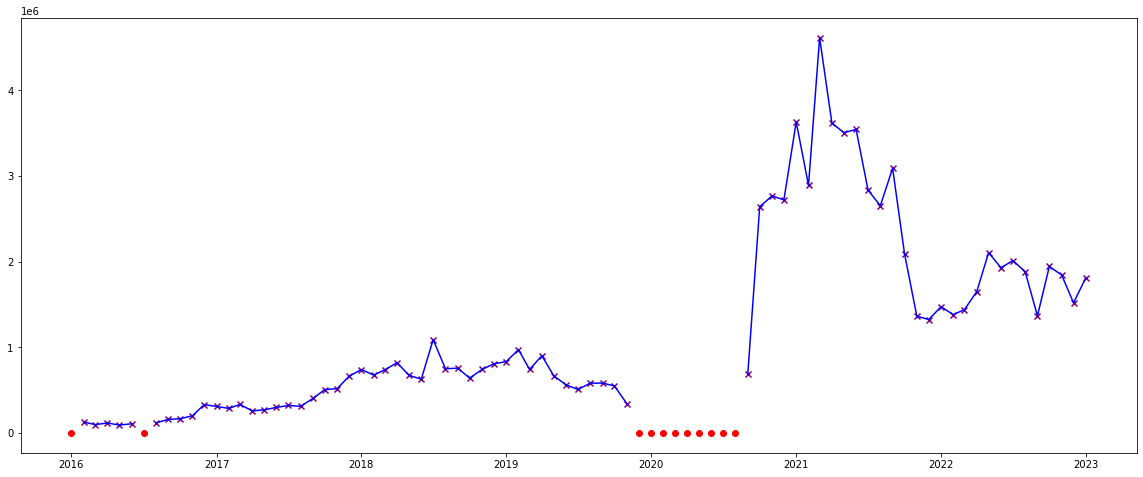

In [80]:
tmp = df_clean[df_clean['Game'] == "Age of Empires II"]
plot_series(df=tmp, feature_name="Hours_watched", show_missing_range = True, show_sample_points=True)

We consider only `[Hours_watched, Hours_Streamed, Peak_viewers]` for prediction of values.

In [34]:
df_clean.corr()

,Rank,Hours_watched,Hours_streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
Rank,1.000000,-0.395769,-0.380141,-0.361592,-0.279556,-0.374547,-0.395753,-0.380222,0.061742
Hours_watched,-0.395769,1.000000,0.752450,0.706356,0.504506,0.741857,0.999586,0.752269,-0.014851
Hours_streamed,-0.380141,0.752450,1.000000,0.558273,0.769005,0.937792,0.752063,0.999572,-0.042215
Peak_viewers,-0.361592,0.706356,0.558273,1.000000,0.516130,0.563618,0.706073,0.558318,0.051956
Peak_channels,-0.279556,0.504506,0.769005,0.516130,1.000000,0.713882,0.505017,0.769889,-0.030282
Streamers,-0.374547,0.741857,0.937792,0.563618,0.713882,1.000000,0.741778,0.937724,-0.044716
Avg_viewers,-0.395753,0.999586,0.752063,0.706073,0.505017,0.741778,1.000000,0.752538,-0.014876
Avg_channels,-0.380222,0.752269,0.999572,0.558318,0.769889,0.937724,0.752538,1.000000,-0.042194
Avg_viewer_ratio,0.061742,-0.014851,-0.042215,0.051956,-0.030282,-0.044716,-0.014876,-0.042194,1.000000


In [35]:
#for game_name in always_on_top:
#    tmp = df_clean[df_clean['Game'] == game_name]
#    plot_series(df=tmp, feature_name="Hours_watched", show_missing_range = True, show_sample_points=True)

In [36]:
date_separation = pd.Timestamp(year=2021, month=12, day=31, hour=0)
print(date_separation)

2021-12-31 00:00:00


In [71]:
# List of top streamed games "ever"
games_train = []
games_test = []

# Threshold which represent the times a game is present in the dataset
nan_threshold_train = 12
nan_threshold_test = 0


# Get the top games
for name in list(df_clean["Game"].unique()):
    is_before_date = df_clean["Date"] <= date_separation
    is_same_name = df_clean['Game'] == name
    #condition = is_before_date & is_same_name
    if (df_clean['Rank'][is_before_date & is_same_name].isna().sum() <= nan_threshold_train):
        games_train.append(name)
    if (df_clean['Rank'][~is_before_date & is_same_name].isna().sum() <= nan_threshold_test):
        games_test.append(name)


print("Training: A total of", len(games_train), "games had at most", nan_threshold_train, "missing values before the test date.")
print("Test: A total of", len(games_test), "games had at most", nan_threshold_test, "missing values after the test date.")
#df_reduced = df_no_duplicates[df_no_duplicates['Game'].isin(always_on_top)].copy()
# why: we want some history also for the test games
games_test = set(games_test).intersection(set(games_train))

games_train, games_test

Training: A total of 61 games had at most 12 missing values before the test date.
Test: A total of 108 games had at most 0 missing values after the test date.


(['7 Days to Die',
  'ARK: Survival Evolved',
  'Age of Empires II',
  'Black Desert Online',
  'Bloodborne',
  'Chess',
  'Clash Royale',
  'Counter-Strike: Global Offensive',
  'Dark Souls',
  'Dark Souls III',
  'DayZ',
  'Dead by Daylight',
  'Diablo III',
  'Dota 2',
  'Dungeons & Dragons',
  'Euro Truck Simulator 2',
  'Games + Demos',
  'Grand Theft Auto V',
  'Guild Wars 2',
  'Gwent: The Witcher Card Game',
  'Hearthstone',
  'Heroes of the Storm',
  'League of Legends',
  'Magic: The Gathering',
  'MapleStory',
  'Mario Kart 8',
  'Minecraft',
  'Music',
  'Overwatch',
  'Paladins',
  'Path of Exile',
  'Poker',
  'Retro',
  'RimWorld',
  'Roblox',
  'Rocket League',
  'RuneScape',
  'Rust',
  'SMITE',
  'Star Citizen',
  'StarCraft II',
  'Stardew Valley',
  'Street Fighter V',
  'Summoners War: Sky Arena',
  'Super Mario 64',
  'Super Smash Bros. Melee',
  'Talk Shows & Podcasts',
  'Terraria',
  'The Elder Scrolls Online',
  'The Elder Scrolls V: Skyrim',
  'The Legend of 

We use data up to the end of 2021 to predict the evolution of streaming data up to Jan 2023.

In [78]:
is_train = (df_clean["Date"] <= date_separation) & (df_clean["Game"].isin(games_train))
is_test = (df_clean["Date"] > date_separation) & (df_clean["Game"].isin(games_test))
df_train = df_clean[is_train]
df_test = df_clean[is_test]

In [77]:
#df_test.groupby(by='Game').agg({'Rank': lambda x: x.isnull().sum()})

## Filling missing values

We compare different methods for filling missing values, and choose one based on RMSE (?)

1. artificially remove some more samples (10% of 84?) for each game and for each feature we predict
2. apply filling method
3. compute RMSE or the other metric and take the mean across everything
4. observe results, take the best one and comment on why?

In [79]:
features = ["Hours_watched", "Hours_streamed", "Peak_viewers"]
game_name = "Age of Empires II"
size_mv = 32
figsize = (15, 5)

In [ ]:
#np.random.seed(42) # seed (to get reproducible results)
#ddata = df_train[df_train["Game"] == game_name].set_index(keys="Date", drop=True)
#mv_idx = np.random.choice(range(len(ddata.index)), size=size_mv, replace=False) # removed values can be values that are already NaN -> they are not considered in the evaluation
#ddata_mv = ddata.copy()
#ddata_mv[feature].iloc[mv_idx] = np.NaN
#util.plot_series(ddata_mv, figsize=(15, 5))
#plt.scatter(ddata.index[mv_idx], ddata[feature].iloc[mv_idx].values, color='tab:orange', marker='x');

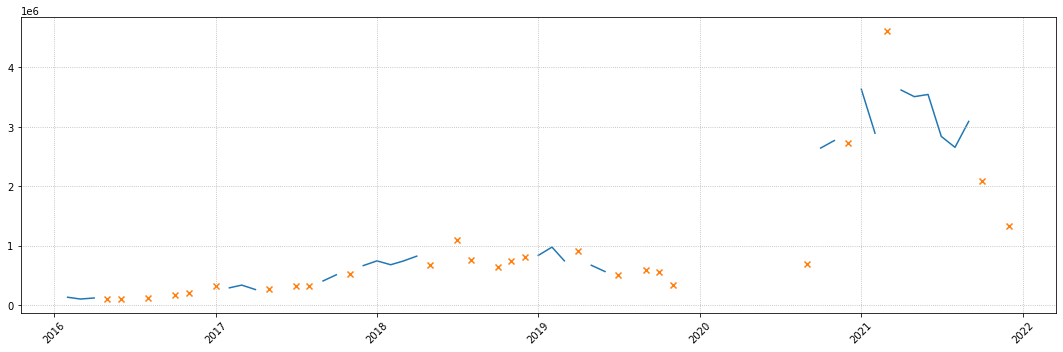

In [75]:
np.random.seed(42) # seed (to get reproducible results)
ddata = df_train[df_train["Game"] == game_name].set_index(keys="Date", drop=True)["Hours_watched"]
mv_idx = np.random.choice(range(len(ddata.index)), size=size_mv, replace=False) # avoid ffill on first element and bfill on last
ddata_mv = ddata.copy()
ddata_mv.iloc[mv_idx] = np.NaN
util.plot_series(ddata_mv, figsize=figsize)
plt.scatter(ddata.index[mv_idx], ddata.iloc[mv_idx], color='tab:orange', marker='x');

In [ ]:
nan_mask = ddata.isnull()
ffseries = ddata_mv.fillna(method='ffill').fillna(method='bfill')
ffseries[nan_mask] = np.NaN # We empty the values that were originally empty
bfseries = ddata_mv.fillna(method='bfill').fillna(method='ffill')
bfseries[nan_mask] = np.NaN # We empty the values that were originally empty

rmse_ff = np.sqrt(mean_squared_error(ddata[~nan_mask], ffseries[~nan_mask]))
rmse_bf = np.sqrt(mean_squared_error(ddata[~nan_mask], bfseries[~nan_mask]))
print(f'RMSE for forwad filling: {rmse_ff:.2f}, for backward filling {rmse_bf:.2f}')

In [ ]:
#util.plot_series(ffseries, figsize=figsize)
#plt.scatter(ddata.index[mv_idx], ddata.iloc[mv_idx], color='tab:orange', marker='x');
#plt.scatter(ddata.index[mv_idx], ffseries.iloc[mv_idx], color='tab:red', marker='x');

In [ ]:
#util.plot_series(bfseries, figsize=figsize)
#plt.scatter(ddata.index[mv_idx], ddata.iloc[mv_idx], color='tab:orange', marker='x');
#plt.scatter(ddata.index[mv_idx], bfseries.iloc[mv_idx], color='tab:red', marker='x');

We try those methods and compute the mean RMSE among games and columns [hours watched, hours streamed, peak viewers].
We normalize the values between

In [ ]:
def fill_gp(ddata_mv):
    # save date index
    old_index = ddata_mv.index
    # convert to numeric index for gp fit
    ddata_mv = ddata_mv.reset_index(drop=True)
    nan_mask_mv = ddata_mv.isna()
    
    kernel = RBF(1, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gp.fit(X=ddata_mv[~nan_mask_mv].index.values.reshape(-1,1), y=ddata_mv[~nan_mask_mv].values) # needs 2D input (pass samples)

    xp, std = gp.predict(ddata_mv.index.values.reshape(-1,1), return_std=True)
    xp = pd.Series(index=ddata_mv.index, data=xp)
    std = pd.Series(index=ddata_mv.index, data=std)
    
    # take as predictions the mean values 
    preds = xp
    preds.index = old_index
    return preds

In [ ]:
args = [{'method':'ffill'}, {'method':'bfill'}, {'method':'linear'}, {'method':'nearest'},
        {'method':'polynomial', 'order': 2}, {'method':'spline', 'order': 4}, {'method': 'GPR'}]

fill_avg_rmse = dict(zip([x['method'] for x in args], [0]*len(args)))
method_for_feature = dict(zip(features, [None]*len(features)))


for feature in features:
        ddata = df_train[df_train["Game"] == game_name].set_index(keys="Date", drop=True)[feature]
        for game_name in df_train["Game"].unique():
                filling_res = {}
                for a in args:
                        if a['method'] == 'GPR':
                                filling_res[a['method']] = fill_gp(ddata_mv=ddata_mv)
                        else:
                                filling_res[a['method']] = ddata_mv.interpolate(**a)
                                if filling_res[a['method']].isna().sum() > 0:
                                        filling_res[a['method']] = filling_res[a['method']].fillna(method='ffill').fillna(method='bfill')
                                        
                        rmse = np.sqrt(mean_squared_error(ddata[~nan_mask], filling_res[a['method']][~nan_mask]))
                        #print(f'RMSE for {a["method"]} on game {game_name} feature {feature}: {rmse:.2f}')
                        fill_avg_rmse[a['method']] += rmse

        for a in args:
                fill_avg_rmse[a['method']] /= len(df_train["Game"].unique())
        print(f"Average RMSE for method on feature {feature}:\n{fill_avg_rmse}")

        fill_method = min(fill_avg_rmse, key=fill_avg_rmse.get)
        fill_method = [a for a in args if a["method"] == fill_method][0]
        method_for_feature[feature] = fill_method
        print(f"Best method for feature {feature}: {fill_method}")   

In [ ]:
df_train_filled = df_train.copy()
for feature in features:
    print(f"Applying {method_for_feature[feature]} filling to {feature}")
    df_train_filled[feature].interpolate(**method_for_feature[feature], inplace=True)
    #assert(df_train_filled[feature].isna().sum()==0)

In [ ]:
tmp = df_train_filled[df_train_filled['Game'] == "Age of Empires II"]
plot_series(df=tmp, feature_name="Hours_streamed", show_missing_range = True, show_sample_points=True)

## Test with GP

Look at index and stuff

gp wants numerical indeces, but ddata and nan mask have date indexes

In [ ]:
mv_idx # idx of values removed from data (for evaluation of filling method)
ddata_mv = ddata.copy()
ddata_mv.iloc[mv_idx] = np.NaN
old_index = ddata_mv.index
ddata_mv = ddata_mv.reset_index(drop=True)

nan_mask_mv = ddata_mv.isna()

kernel = RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X=ddata_mv[~nan_mask_mv].index.values.reshape(-1,1), y=ddata_mv[~nan_mask_mv].values) # needs 2D input (pass samples)

xp, std = gp.predict(ddata_mv.index.values.reshape(-1,1), return_std=True)
xp = pd.Series(index=ddata_mv.index, data=xp)
std = pd.Series(index=ddata_mv.index, data=std)

xp.index = old_index
ddata_mv.index = old_index
std.index = old_index
nan_mask_mv.index = old_index
mean_squared_error(ddata[~nan_mask], xp[~nan_mask])

In [ ]:
ddata_mv = ddata.copy()
ddata_mv.iloc[mv_idx] = np.NaN
preds = fill_gp(ddata_mv=ddata_mv)
mean_squared_error(ddata[~nan_mask], preds[~nan_mask])

In [ ]:
util.plot_series(ddata_mv, figsize=figsize)
util.plot_series(ddata, figsize=figsize)

In [ ]:
util.plot_gp(target=ddata_mv, samples=ddata_mv[~nan_mask_mv], pred=xp, std=std, figsize=figsize)